# Credit Card Fraud Detection - Model Training

This notebook focuses on training a baseline Logistic Regression model for the `creditcard.csv` dataset.
Since this dataset is highly imbalanced, we will apply SMOTE (Synthetic Minority Over-sampling Technique) to the training data.


In [9]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Add the src directory to the path to import modules
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from eda_fraud_data import Eda

# Load Data
data_path = '../data/raw/creditcard.csv'
try:
    df = pd.read_csv(data_path)
    print(f"Data loaded. Shape: {df.shape}")
except FileNotFoundError:
    print("File not found. Please check the path.")

Data loaded. Shape: (284807, 31)


## Exploratory Data Analysis (EDA)

We will perform a quick EDA to understand the dataset structure and class distribution.
- **Time**: Seconds elapsed between each transaction and the first transaction.
- **Amount**: Transaction amount.
- **V1-V28**: PCA transformed features (anonymized).
- **Class**: 0 (Legitimate), 1 (Fraud).

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float

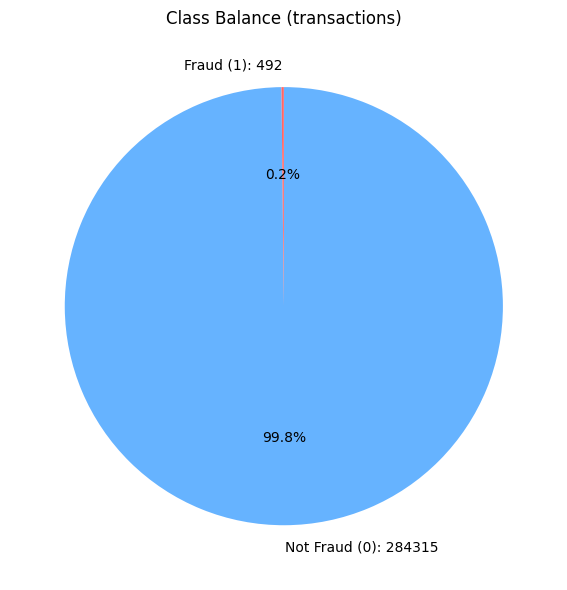

Class
0    284315
1       492
Name: count, dtype: int64

In [10]:
# Initialize EDA class
eda = Eda(df)

# Basic Info
eda.basic_exploration()

# Check Missing Values
eda.check_missing_values()

# Plot Class Balance
eda.plot_class_balance(target='Class')

## Data Preprocessing and Resampling

Since the dataset is highly imbalanced, we will:
1.  Scale `Amount` and `Time` (V1-V28 are already scaled).
2.  Split the data into Train and Test sets.
3.  Apply **SMOTE** to the Training set only.

In [11]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from modelling import FraudModel

# 1. Scale 'Amount' and 'Time'
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])
df['Time'] = scaler.fit_transform(df[['Time']])

# 2. Separate Features and Target
X = df.drop(columns=['Class'])
y = df['Class']

# 3. Split Data (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Apply SMOTE to Training Data Only
print("\nApplying SMOTE...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class Balance After SMOTE (Train):\n", y_train_resampled.value_counts(normalize=True))


Applying SMOTE...
Class Balance After SMOTE (Train):
 Class
0    0.5
1    0.5
Name: proportion, dtype: float64
Class Balance After SMOTE (Train):
 Class
0    0.5
1    0.5
Name: proportion, dtype: float64


## Model Training and Evaluation 

We will train a Logistic Regression model on the resampled data and evaluate it on the original test set.

In [12]:
# Initialize Model Class
fraud_model = FraudModel()

# Train Logistic Regression on Resampled Data
model = fraud_model.train_logistic_regression(X_train_resampled, y_train_resampled, max_iter=1000, random_state=42)


--- Training Logistic Regression ---
Model training completed.
Model training completed.



--- Model Evaluation ---


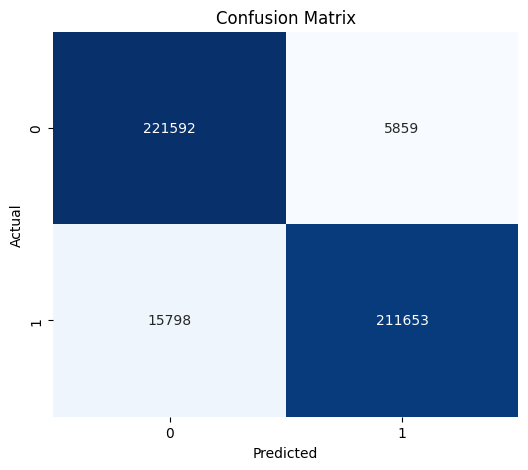


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95    227451
           1       0.97      0.93      0.95    227451

    accuracy                           0.95    454902
   macro avg       0.95      0.95      0.95    454902
weighted avg       0.95      0.95      0.95    454902

ROC-AUC Score: 0.9916
              precision    recall  f1-score   support

           0       0.93      0.97      0.95    227451
           1       0.97      0.93      0.95    227451

    accuracy                           0.95    454902
   macro avg       0.95      0.95      0.95    454902
weighted avg       0.95      0.95      0.95    454902

ROC-AUC Score: 0.9916
AUC-PR Score: 0.9925
AUC-PR Score: 0.9925


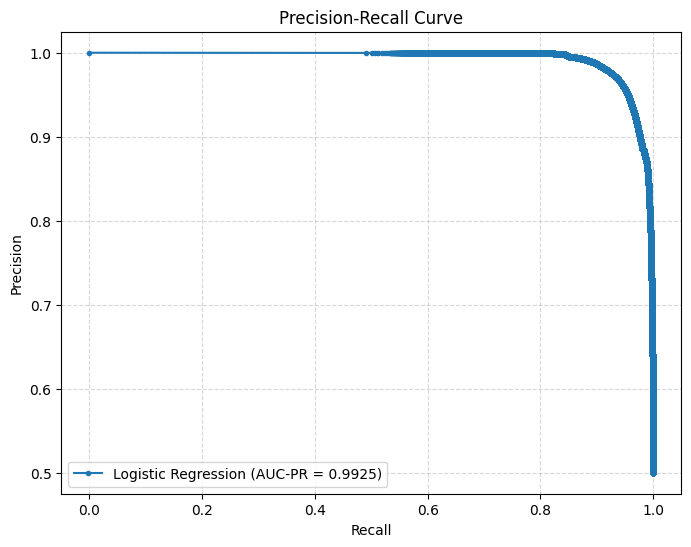

In [13]:
# Evaluate on Train Data 
metrics = fraud_model.evaluate_model(X_train_resampled, y_train_resampled)

# Evaluate model performance on train set

### 📊 Training Set Interpretation (Resampled/Balanced Data)

**1. The "SMOTE Effect" (Near Perfect Scores):**
*   **Recall (0.93) & Precision (0.97):** The model performs exceptionally well here.
*   **Why?** We are evaluating on the **Resampled** data (50% Fraud, 50% Legit). The model has learned to distinguish these two balanced groups almost perfectly.
*   **Confusion Matrix:**
    *   **True Positives (211,653):** It correctly identified the vast majority of the synthetic fraud cases.
    *   **False Positives (5,859):** Very low compared to the total count.

**2. AUC-PR (0.99):**
*   **Meaning:** The curve stays flat at the top (High Precision) almost all the way to the right (High Recall).
*   **Interpretation:** This confirms the model has successfully "learned" the training data. It is not just guessing; it found real patterns in the PCA features.

**3. Caution:**
*   Do not mistake this for real-world performance! In the real world (Test Set), the data is not 50/50. The Precision will drop significantly there# filepath: c:\Users\yeget\Improved-detection-of-fraud-cases-for-e-commerce-and-bank-transactions\notebooks\modelling-credit-data.ipynb

# Evaluate model performance on test set


--- Model Evaluation ---


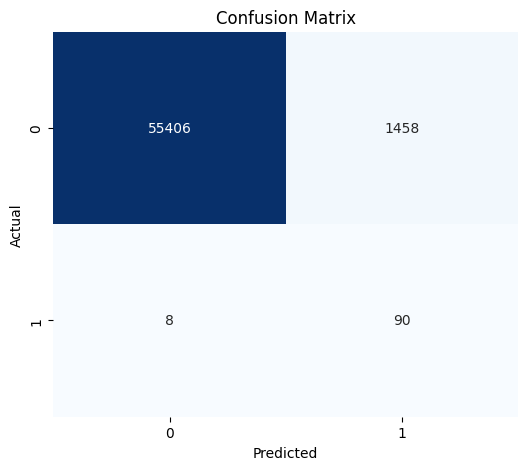


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

ROC-AUC Score: 0.9698
AUC-PR Score: 0.7703


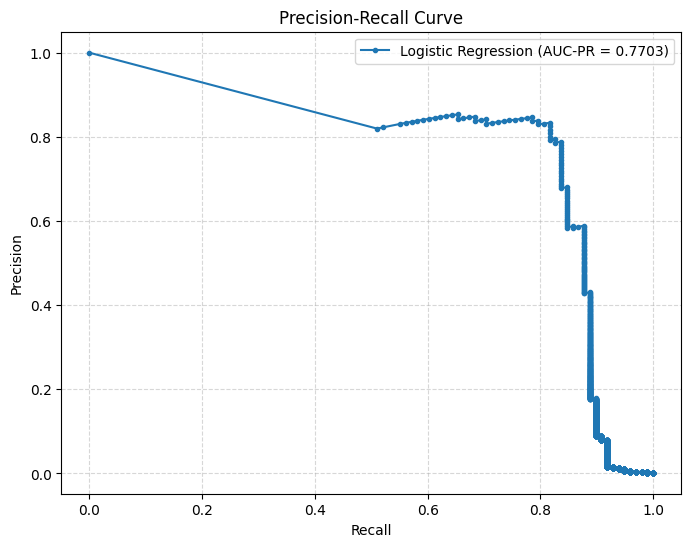

In [14]:
# Evaluate on Test Data (Original distribution)
metrics = fraud_model.evaluate_model(X_test, y_test)

### 📉 Test Set Interpretation (Real-World Generalization)

**1. The Reality Check (Train vs. Test):**
*   **Recall (Stability):**
    *   **Train (Resampled):** 0.93
    *   **Test (Real-World):** 0.92
    *   **Verdict:** **Excellent.** The model did not "forget" how to find fraud when moving to unseen data. It captures 90 out of 98 actual fraud cases.
*   **Precision (The Drop):**
    *   **Train (Resampled):** 0.97
    *   **Test (Real-World):** 0.06
    *   **Verdict:** **Expected Drop.** This is not overfitting; it is the **Imbalance Effect**.
    *   *Explanation:* In the training set (50/50), it's easy to have high precision. In the test set, legitimate transactions outnumber fraud by ~500:1. Even a tiny error rate on the legitimate transactions generates enough False Positives (1,458) to drown out the True Positives (90), crashing the precision score.

**2. Business Impact:**
*   **Security (Recall = 0.92):**
    *   **Result:** We caught **90 out of 98** fraud cases.
    *   **Missed:** Only **8** fraud cases slipped through.
    *   **Assessment:** This is a highly secure model. The PCA features are doing a heavy lifting here.

*   **Customer Experience (Precision = 0.06):**
    *   **Result:** To catch those 90 fraudsters, we annoyed **1,458** innocent customers (False Positives).
    *   **Assessment:** This is the trade-off. The model is "paranoid" (tuned by SMOTE to be sensitive).

**3. Comparison with `Fraud_Data.csv`:**
*   **Credit Card Data:** AUC-PR **0.77**, Recall **0.92**.
*   **E-Commerce Data:** AUC-PR **0.36**, Recall **0.70**.
*   **Conclusion:** The `creditcard.csv` features (`V1-V28`) are much higher quality than our manual engineering.

**4. Final Recommendation:**
*   The AUC-PR of **0.77** is actually very strong for such an imbalanced dataset.
*   To fix the low precision,# filepath: c:\Users\yeget\Improved-detection-of-fraud-cases-for-e-commerce-and-bank-transactions\notebooks\modelling-credit-data.ipynb